# Imports

In [132]:
import re
import sqlite3

from numpy import *

import numpy             as np
import pandas            as pd
import seaborn           as sns
import umap.umap_        as umap
import statistics        as st

from sklearn             import mixture       as mx
from sklearn             import cluster       as c
from sklearn             import metrics
from sklearn             import decomposition as dd
from plotly              import express       as px
from matplotlib          import pyplot        as plt
from sklearn             import preprocessing as pp
from sklearn             import ensemble      as en
from scipy.cluster       import hierarchy     as hc

from sklearn.neighbors   import NearestNeighbors
from sklearn.manifold    import TSNE
from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sqlalchemy       import create_engine

# Data Import

In [90]:
#load data
df = pd.read_csv('Ecommerce.csv',encoding="ISO-8859-1")

#drop
df = df.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [91]:
df1 = df.copy()

## 1.1. Rename Columns 

In [92]:
cols_new = df1.columns

cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [93]:
print('Number of columns: ', df1.shape[1])
print('Number of rows: ', df1.shape[0])

Number of columns:  8
Number of rows:  541909


## 1.3. Data Type

In [94]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. NA Check

In [95]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [96]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [97]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop
df1 = df1.drop(columns=['customer_id_x','customer_id_y'],axis=1)

## 1.6. Change Types

In [98]:
#invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7. Descriptive Statistics

In [99]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(include = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numeric Attributes

In [100]:
#central tendency - mean, median, mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(num_attributes.apply(st.mode)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,ct3,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,1.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,1.25,96.759764,186.506972,59005.719097


### 1.7.2. Categorical Attributes

In [101]:
#invoice no
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

print('Total number of invoices:{}'.format(len(df_letter_invoices)))
print('Total number of negatives quantity:{}'.format(len(df_letter_invoices[df_letter_invoices['quantity']<0])))

Total number of invoices:9291
Total number of negatives quantity:9288


In [102]:
#check stock code
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [103]:
#country
df1['country'].unique()

df1['country'].value_counts(normalize=True).head()

df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Variable Filtering

In [104]:
df2 = df1.copy()

In [105]:
#numerical attributes 
#unit price
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#desription
#df2 = df2.drop(columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad user
df2 = df2[~df2['customer_id'].isin([16446])]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

In [106]:
df2_purchase.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

# 3.0 Feature Engineering

In [107]:
#df3 = df2.copy()

## 3.1. Feature Creation

In [108]:
#data ref
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [109]:
#gross revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

#monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

C:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency

In [110]:
#recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.4. Quantity of products purchased

In [111]:
#quantity of products
df_frequency = (df2_purchase[['customer_id','stock_code']].groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns={'stock_code':'quantity_products'}))
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
dtype: int64

### 3.1.7. Frequency

In [112]:
#df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
#df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
#df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_=('invoice_date', 'max'),
                                                                 min_=('invoice_date', 'min'),
                                                                 days_=('invoice_date', 
                                                                          lambda x: ((x.max() - x.min()).days)+1),
                                                                 buy_=('invoice_no','count'))).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
frequency            91
dtype: int64

### 3.1.8. Number of returns

In [113]:
#number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby(
    'customer_id').sum().reset_index().rename(columns={'quantity':'quantity_returns'})
df_returns['quantity_returns'] = df_returns['quantity_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['quantity_returns'].isna(), 'quantity_returns'] = 0

df_ref.isna().sum()


customer_id           0
gross_revenue        91
recency_days         91
quantity_products    91
frequency            91
quantity_returns      0
dtype: int64

# 4.0 EDA

In [114]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id          0
gross_revenue        0
recency_days         0
quantity_products    0
frequency            0
quantity_returns     0
dtype: int64

## 4.3. Space Study

In [115]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'quantity_products', 'frequency', 'quantity_returns']
df43 = df4[cols_selected].copy()

In [116]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['quantity_products'] = mm.fit_transform(df43[['quantity_products']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['quantity_returns'] = mm.fit_transform(df43[['quantity_returns']])

### 4.3.2. Tree-Based Embeding

C:\Users\Henrique\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

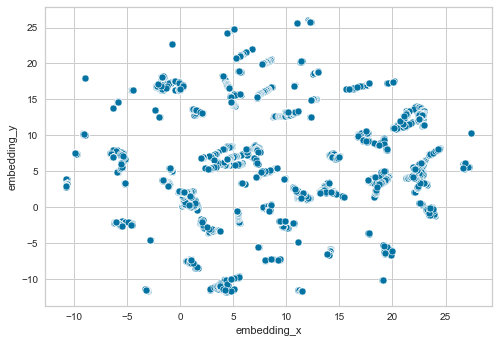

In [117]:
#training dataset
X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

#model training
rf_model.fit(X,y)

#leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

#reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
               data=df_tree)

# 5.0 Data Preparation

In [118]:
df5 = df_tree.copy()

# 6.0 Feature Selection

In [119]:
df6 = df_tree.copy()

# 7.0 Hyperparameter Fine-Tuning

In [120]:
X = df_tree.copy()

In [121]:
X.head()

,embedding_x,embedding_y
0,18.870157,8.606273
1,16.812176,9.711937
2,18.476212,8.798081
3,-5.689691,-2.300382
4,11.340823,20.240604


# 8.0 Model Training

## 8.1. Final Model - GMM

In [140]:
k=8

#model definition
gmm = mx.GaussianMixture(n_components=k, n_init=300, random_state=32)

#model traing
gmm.fit(X)

#model predict
labels = gmm.predict(X)

In [141]:
#SS
print('SS value: {}'.format(metrics.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.3614770174026489


# 9.0 Cluster Analysis

In [142]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

df92['recency_days'] = df92['recency_days'].astype(int)
df92['quantity_products'] = df92['quantity_products'].astype(int)
df92['quantity_returns'] = df92['quantity_returns'].astype(int)

In [143]:
#number of customer
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

#average gross revenue
df_avg_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#average recency days
df_avg_recency_day = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_day, how='inner', on='cluster')

#average invoice_no
df_quantity_products = df92[['quantity_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_quantity_products, how='inner', on='cluster')

#frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

#returns
df_quantity_returns = df92[['quantity_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_quantity_returns, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

#5 Cluster Insiders
#2 Cluster More Products
#4 Cluster Spend Money
#7 Cluster Even More Products
#3 Cluster Less Days
#0 Cluster Less 1K
#1 Custer Stop Returners
#6 Cluster More Buy

,cluster,customer_id,perc_customer,gross_revenue,recency_days,quantity_products,frequency,quantity_returns
5,5,159,2.791923,4212.000943,46.018868,109.528302,0.047168,23.566038
2,2,652,11.448639,2919.465521,82.460123,193.375767,0.364934,26.524540
4,4,1267,22.247586,2705.333023,131.198106,106.505130,0.552031,108.532755
7,7,959,16.839333,2499.363264,87.661105,174.076121,0.376326,6.323253
3,3,362,6.356453,1251.643204,60.132597,54.334254,0.027978,10.016575
0,0,517,9.078139,819.715822,79.941973,29.657640,0.176975,3.965184
1,1,936,16.435470,525.225983,163.978632,30.958333,1.022524,1.933761
6,6,843,14.802458,392.666584,163.639383,21.172005,0.892485,7.081851


# 10.0 Exploratory Data Analysis

In [137]:
#create table
query_create_table_insiders = """
    CREATE TABLE insiders(
        customer_id        INTEGER,
        gross_revenue      REAL,
        recency_days       INTEGER,
        quantity_products  INTEGER,
        frequency          REAL,
        quantity_returns   INTEGER,
        cluster            INTEGER)
        """

conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()



OperationalError: table insiders already exists

In [134]:
#insert data
conn = create_engine('sqlite:///insiders_db.sqlite')
df92.to_sql('insiders', con=conn, if_exists='append', index=False)

In [135]:
#consulting database
query = """
    SELECT * FROM insiders
    """

df = pd.read_sql_query(query,conn)

In [136]:
df.head()

,customer_id,gross_revenue,recency_days,quantity_products,frequency,quantity_returns,cluster
0,17850,5391.21,372,297,17.000000,40,2
1,13047,3232.59,56,171,0.028302,35,2
2,12583,6705.38,2,232,0.040323,50,2
3,13748,948.25,95,28,0.017921,0,0
4,15100,876.00,333,3,0.073171,22,4
